<a href="https://colab.research.google.com/github/RiccardoRobb/BigData_project/blob/main/BigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Twitter sentiment analysis**
### BigData 2023 project

[@Author](https://github.com/RiccardoRobb): Riccardo Ruberto 1860609

---
## **Inital configuration**
### PySpark installation

In [1]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1a931c133258aa99554c511d0daea526e64333ca32dc1dcde7b5606e85cb1814
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


### Useful imports

In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Spark configuration

In [3]:
# create the session
conf = SparkConf().\
                set('spark.ui.port', "8000").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("Twitter sentiment analysis").\
                setMaster("local[*]")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Check spark configurations

In [4]:
spark

In [5]:
sc._conf.getAll()

[('spark.driver.host', '9e051fcb5db8'),
 ('spark.app.submitTime', '1688463303215'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.ui.port', '8000'),
 ('spark.app.startTime', '1688463303493'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action

---
## Load dataset [***Sentiment140***]
### Download dataset

In [6]:
! wget https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip

! unzip "./*.zip" && rm *.zip
! mv training.1600000.processed.noemoticon.csv train140.csv

--2023-07-04 09:35:08--  https://raw.githubusercontent.com/RiccardoRobb/BigData_project/main/Sentiment140.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84855679 (81M) [application/zip]
Saving to: ‘Sentiment140.zip’

Sentiment140.zip    100%[===================>]  80.92M   196MB/s    in 0.4s    

2023-07-04 09:35:09 (196 MB/s) - ‘Sentiment140.zip’ saved [84855679/84855679]

Archive:  ./Sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


### Create data frame [***Sentiment140***]
1600000 tweets

In [7]:
schema = StructType([ \
    StructField("target",IntegerType(),True), \
    StructField("id",LongType(),True), \
    StructField("full_date",StringType(),True), \
    StructField("flag", StringType(), True), \
    StructField("user", StringType(), True), \
    StructField("text", StringType(), True) \
  ])

df = spark.read.csv('./train140.csv', schema=schema, header="false")

---
## **Inital cleaning**
### Removal of unnecessary columns

In [8]:
# sentiment of the tweet is not affected by the "user"
df = df.drop("user")

# verify "flag" utility
print(df.select(countDistinct("flag")).collect()[0][0])

# "flag" has only one value == NO_QUERY, so I delete it
df = df.drop("flag")

1


### From ***date*** to ***day_name***; ***hour***; ***date***

In [9]:
months_map = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}

convert_date_udf = udf(lambda month_name : months_map[month_name], StringType())

### From **hour:min:mill** to int **hour**

In [10]:
convert_hour_udf = udf(lambda time: int(time[:2]), IntegerType())

In [11]:
split_col = pyspark.sql.functions.split(df['full_date'], ' ')

df = df.withColumn("day_name", split_col.getItem(0)) \
      .withColumn("hour", convert_hour_udf(split_col.getItem(3))) \
      .withColumn("date", to_date( concat_ws("-", split_col.getItem(2), convert_date_udf(split_col.getItem(1)), split_col.getItem(5)), "dd-MM-yyyy"))

df = df.drop("full_date")

---
## **Data analysis**
### ***target*** values analisys

In [12]:
#df.select("target").distinct().show()
# "target" value is or 0 or 4

In [13]:
sad_tweets = df.filter(col("target") == 0)
happy_tweets = df.filter(col("target") == 4)

print("Sad tweets = ", sad_tweets.count())
print("Happy tweets = ", happy_tweets.count())

Sad tweets =  800000
Happy tweets =  800000


Sad tweets and happy tweets are balanced.

### Time frame of interest

In [14]:
print("Min date = ", df.select(min(df.date)).collect()[0][0])
print("Max date = ", df.select(max(df.date)).collect()[0][0])

Min date =  2009-04-06
Max date =  2009-06-25


The time frame used is too small, datas were collected in 2 months. \\
*Using data column will be useful only if we try to predict tweets written during the [2009-04-06, 2009-06-25] period.*

### Better to delete the ***date*** column

In [15]:
df = df.drop("date")

---
## **Data processing**
### Case normalization

In [16]:
# used for all columns to see if null values are present
# df.filter(col("text").isNull()).show()

df = df.withColumn("text", lower(col("text")))

### Username and links removal

In [17]:
import re

# twitter ids can contain alphanumeric and '_' characters
username_regex = r"@[A-Za-z0-9_]+"

# http:// / https:// links
link_regex1 = r"https?://[^ ]+"

# www. links
link_regex2 = r"www.[^ ]+"


master_regex = r"|".join((username_regex, link_regex1, link_regex2))

df = df.withColumn("text", regexp_replace(df.text, master_regex, ""))

### Filter out punctual symbols

In [18]:
df = df.withColumn("text", regexp_replace(df.text, "[^a-zA-Z\s]", ""))

### Trimming

In [19]:
df = df.withColumn("text", trim(col("text")))

# extra whitespaces
df = df.withColumn("text", trim(regexp_replace(df.text, " +", " ")))

### Tokenization

In [20]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "text", outputCol = "tokens")
tokens_df = tokenizer.transform(df)

### Stopwords removal

In [21]:
from pyspark.ml.feature import StopWordsRemover

stopwords_remover = StopWordsRemover(inputCol = "tokens", outputCol = "terms")
terms_df = stopwords_remover.transform(tokens_df)

### Stemming

In [22]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language = "english")
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))


tweets_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))

### Removal of unnecessary columns

In [23]:
tweets_df = tweets_df.drop("id", "text", "tokens", "terms")

#tweets_df.show(7, truncate = False)

---
## **Additional cleaning**

In [24]:
tweets_df.cache()

tweets_df = tweets_df.filter(size(tweets_df.terms_stemmed) > 1)

sad_tweets = tweets_df.filter(tweets_df.target == 0)
happy_tweets = tweets_df.filter(tweets_df.target == 4)

sad_tweets_count = sad_tweets.count()
happy_tweets_count = happy_tweets.count()

print("Sad tweets = ", sad_tweets_count)
print("Happy tweets = ", happy_tweets_count)

Sad tweets =  774763
Happy tweets =  767489


### After the cleaning Sad and Happy tweets are ***unbalanced***

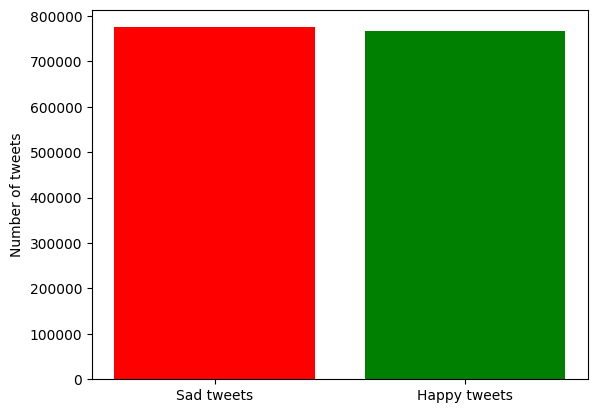

In [25]:
(figure_, axes_) = plt.subplots()

y = [sad_tweets_count, happy_tweets_count]
axes_.set_ylabel("Number of tweets")

x = ["Sad tweets", "Happy tweets"]

axes_.bar(x, y, color = ["red", "green"])
plt.show()

### Balancing dataframes

In [26]:
sad_tweets = sad_tweets.select("*").orderBy(rand())
sad_tweets = sad_tweets.limit(happy_tweets_count)

tweets_df = sad_tweets.union(happy_tweets)

---
## **Word Vector representation**

### Load **GloVe** embeddings

In [27]:
import gensim.downloader as api

embeddings = 100
word2vector = None

if word2vector == None:
  word2vector = api.load("glove-twitter-" + str(embeddings))

[==================================================] 100.0% 387.1/387.1MB downloaded


### Mapping tokens - embeddings

In [28]:
extractor_udf = udf(lambda tokens: [[float(x) for x in word2vector[token]] if token in word2vector else [float(0.0)]*word2vector["tweet"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))

avg_embedding_udf = udf(lambda x :[float(y) for y in np.mean(x, axis = 0)])

tweets_embedded = tweets_df.withColumn("tweet_embeddings", extractor_udf("terms_stemmed"))
tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", avg_embedding_udf("tweet_embeddings"))

tweets_embedded.printSchema()
tweets_embedded.show(7, truncate = False)


root
 |-- target: integer (nullable = true)
 |-- day_name: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- terms_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tweet_embeddings: string (nullable = true)

+------+--------+----+--------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Conversion from `ArrayType( ArrayType( Float() ) )` to `VectorUDT()`

In [29]:
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector_udf = udf(lambda embedded: Vectors.dense(embedded), VectorUDT())

tweets_embedded = tweets_embedded.withColumn("tweet_embeddings", to_vector_udf(tweets_embedded.tweet_embeddings))


---
## **Train and Test setup**

In [30]:
#tweets_embedded.cache()

(train_df, test_df) = tweets_embedded.randomSplit([0.8, 0.2], seed=1234)

train_df_count = train_df.count()

### **Assign weights** to unbalanced columns

In [31]:
# calculate the weights for the train set
class_weights_train = train_df.groupBy('target').count().withColumn('class_weight_train', 1 / col('count'))
hour_weights_train = train_df.groupBy('hour').count().withColumn('hour_weight_train', col('count') / train_df_count)
day_weights_train = train_df.groupBy('day_name').count().withColumn('day_weight_train', col('count') / train_df_count)

# join the weights
train_df_weighted = train_df.join(class_weights_train, 'target', 'left').join(hour_weights_train, 'hour', 'left').join(day_weights_train, 'day_name', 'left')

# fill null values in case of missing values
train_df_weighted = train_df_weighted.fillna(0.0, subset=['class_weight_train', 'hour_weight_train', 'day_weight_train'])

train_df_weighted = train_df_weighted.withColumn('terms_stemmed', col('terms_stemmed'))
train_df_weighted = train_df_weighted.withColumn('tweet_embeddings', col('tweet_embeddings'))

# delete "count" columns
#  cannot delate columns with the same name, so I rename them
df_cols = train_df_weighted.columns

duplicate_col_index = [idx for idx, val in enumerate(df_cols) if val in df_cols[:idx]]

cols_to_remove = list()

for i in duplicate_col_index:
    df_cols[i] = 'count_'+ str(i)
    cols_to_remove.append(col(df_cols[i]))

train_df_weighted = train_df_weighted.toDF(*df_cols)

cols_to_remove.append(col("count"))
train_df_weighted = train_df_weighted.drop(*cols_to_remove)

#train_df_weighted.show(5)


### Combine weighted columns

In [32]:
from pyspark.ml.feature import VectorAssembler, CountVectorizer

train_df_weighted = train_df_weighted.withColumn("combined_weight", train_df_weighted["class_weight_train"] * train_df_weighted["hour_weight_train"] * train_df_weighted["day_weight_train"])
test_df = test_df.withColumn("combined_weight", lit(1.0))

assembler = VectorAssembler(inputCols = ["hour", "day_name", "tweet_embeddings"], outputCol = "features")

# before the VectorAssembler I need to handle the string data "day_name"
days_map = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}

convert_day_name_udf = udf(lambda day_name : days_map[day_name], IntegerType())

train_df_weighted = train_df_weighted.withColumn("day_name", convert_day_name_udf(train_df_weighted.day_name))
test_df = test_df.withColumn("day_name", convert_day_name_udf(test_df.day_name))

# apply the VectorAssembler
train_df_weighted = assembler.transform(train_df_weighted).select("features", "target", "combined_weight")
test_df = assembler.transform(test_df).select("features", "target", "combined_weight")

## **Load ready-to-use dataset**
Load train and test cleaned and preprocessed datasetes `.parquet`

In [33]:
#from google.colab import files

#train_dataset_parquet = files.upload()
#test_dataset_parquet = files.upload()

## **Logistic Regression**

In [34]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='target', weightCol='combined_weight')
lr_model = lr.fit(train_df_weighted)

predictions = lr_model.transform(test_df)

### Save model

In [41]:
lr_model.save("LogisticRegressionModel")

### Calculate accuracy

In [40]:
correct_predictions = predictions.filter(predictions.prediction == predictions.target).count()
total_predictions = predictions.count()

accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

Accuracy: 0.7135691175703178


---
## Verify data

In [35]:
#tweets_embedded.printSchema()
#tweets_embedded.show(10)

#print("tot = ", tweets_embedded.count())

# TODO
* **Are useful tokens with len==1 ?**
* **chek udf validity for month/day mapping**
* **validation set?**